In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import torch, math
import torch.nn as nn
import torch.nn.functional as F
from numbers import Number

In [144]:
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """

    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        
        self.padding = kernel_size // 2
        
        if isinstance(kernel_size, Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, Number):
            sigma = [sigma] * dim
        

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

    def forward(self, x):
        x = F.pad(x, (self.padding, self.padding), mode='reflect')
        x = F.conv1d(x, weight=self.weight, groups=self.groups)
        return x
        #return self.conv(input, weight=self.weight, groups=self.groups, padding=self.padding)

In [80]:
cols = ['acceleration_x', 'acceleration_y', 'acceleration_z',
        'input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll'
       ]

In [81]:
data = pd.read_csv('data/interpolation/interpolation_00.csv')
data

timestamp  acceleration_x  acceleration_y  acceleration_z  \
0      1.020121e+12        0.591386        9.818921       -0.787716   
1      1.020133e+12        0.608542        9.883211       -0.789847   
2      1.020145e+12        0.614358        9.786939       -0.786015   
3      1.020157e+12        0.599924        9.667338       -0.796326   
4      1.020168e+12        0.601040        9.711021       -0.792891   
...             ...             ...             ...             ...   
20501  1.261213e+12       -0.269839        9.461371       -2.565860   
20502  1.261225e+12       -0.256187        9.477637       -2.568961   
20503  1.261237e+12       -0.249204        9.467586       -2.566912   
20504  1.261248e+12       -0.240966        9.451741       -2.588867   
20505  1.261260e+12       -0.245460        9.453265       -2.589615   

       angular_vec_x  angular_vec_y  angular_vec_z  input_orientation_x  \
0          -0.007071       0.003447      -0.002072             0.051709   
1           0.010745      -0.003407      -0.008484             0.052227   
2           0.012159      -0.005893      -0.013466             0.052378   
3           0.007424      -0.008523      -0.010310             0.052418   
4          -0.000430      -0.011982      -0.009481             0.051973   
...              ...            ...            ...                  ...   
20501       0.030742       0.010633      -0.002561             0.143394   
20502       0.030421       0.016224      -0.001079             0.143922   
20503       0.032082       0.017777      -0.002963             0.144281   
20504       0.033581       0.020835      -0.005853             0.144444   
20505       0.034216       0.025838      -0.009402             0.144803   

       input_orientation_y  input_orientation_z  input_orientation_w  \
0                 0.054229             0.016040             0.997060   
1                 0.054400             0.015926             0.997025   
2                 0.054239             0.015692             0.997030   
3                 0.054180             0.015804             0.997029   
4                 0.053933             0.015796             0.997066   
...                    ...                  ...                  ...   
20501             0.003307            -0.021773             0.989420   
20502             0.003775            -0.021899             0.989339   
20503             0.004030            -0.022044             0.989283   
20504             0.004413            -0.022074             0.989257   
20505             0.004674            -0.022254             0.989199   

       input_orientation_yaw  input_orientation_pitch  input_orientation_roll  
0                   0.106758                 0.101622                0.037603  
1                   0.107091                 0.102662                0.037449  
2                   0.106789                 0.102994                0.036981  
3                   0.106658                 0.103066                0.037203  
4                   0.106180                 0.102186                0.037114  
...                      ...                      ...                     ...  
20501               0.012799                 0.288120               -0.042149  
20502               0.013786                 0.289211               -0.042258  
20503               0.014348                 0.289951               -0.042466  
20504               0.015122                 0.290296               -0.042411  
20505               0.015706                 0.291039               -0.042687  

[20506 rows x 14 columns]

In [145]:
g = GaussianSmoothing(channels=1, kernel_size=13, sigma=2, dim=1)
wavelet = 'db1'

/home/shim/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shim/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/shim/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous ax

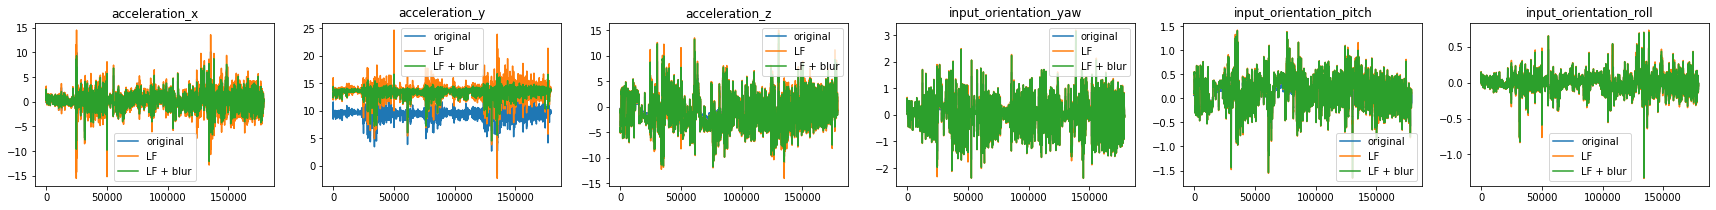

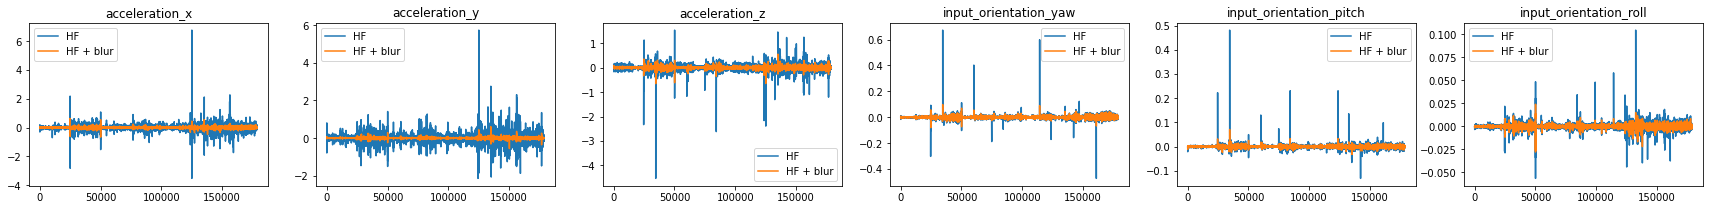

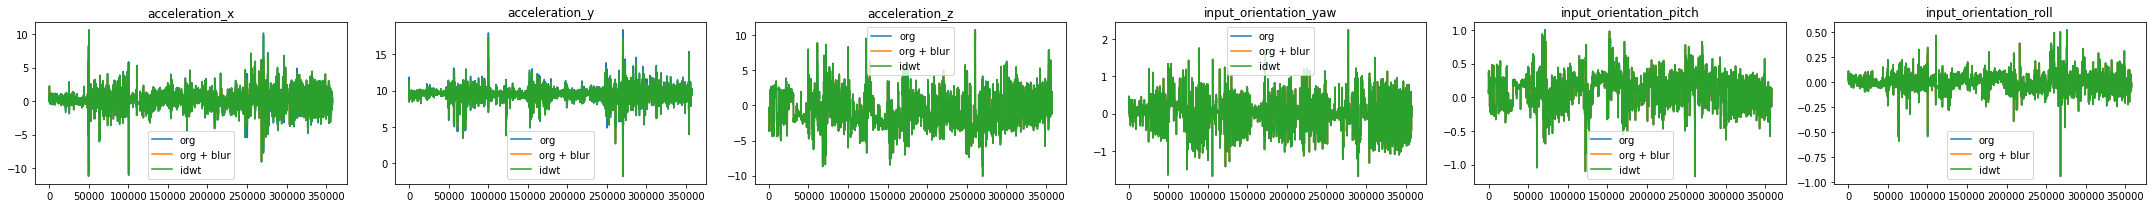

In [150]:
data = pd.concat([pd.read_csv(f'data/interpolation/interpolation_{j:02d}.csv') for j in range(22)])


# LF + org
plt.figure(figsize=(30, 3))
for i, col in enumerate(cols, 1):
    d = data[col].to_numpy()
    l, h = pywt.dwt(d, wavelet)
    plt.subplot(1, len(cols), i)
    plt.plot(d[::2])
    plt.plot(l)
    l = torch.tensor(l, dtype=torch.float32).view(1, 1, -1)
    l = g(l)
    l = l.squeeze().numpy()
    plt.plot(l)
    plt.title(col)
    plt.legend(['original', 'LF', 'LF + blur'])

# HF
plt.figure(figsize=(30, 3))
for i, col in enumerate(cols, 1):
    d = data[col].to_numpy()
    l, h = pywt.dwt(d, wavelet)
    plt.subplot(1, len(cols), i)
    plt.plot(h)
    
    h = torch.tensor(h, dtype=torch.float32).view(1, 1, -1)
    h = g(h)
    h = h.squeeze().numpy()
    plt.plot(h)
    
    #plt.ylim(-1, 1)
    plt.title(col)
    plt.legend(['HF', 'HF + blur'])
    
# org : idwt
plt.figure(figsize=(30, 3))
for i, col in enumerate(cols, 1):
    d = data[col].to_numpy()
    l, h = pywt.dwt(d, wavelet)
        
    plt.subplot(1, len(cols), i)
    plt.plot(d, zorder=0)

    d = torch.tensor(d, dtype=torch.float32).view(1, 1, -1)
    d = g(d)
    d = d.squeeze().numpy()
    
    h = torch.tensor(h, dtype=torch.float32).view(1, 1, -1)
    h = g(h)
    h = h.squeeze().numpy()
    
    idwt = pywt.idwt(l, h, wavelet)
    
    plt.subplot(1, len(cols), i)
    plt.plot(d)
    plt.plot(idwt)
    
    #plt.ylim(-1, 1)
    plt.title(col)
    plt.legend(['org', 'org + blur', 'idwt'])
    
plt.tight_layout()
plt.show()

data/interpolation/interpolation_00.csv


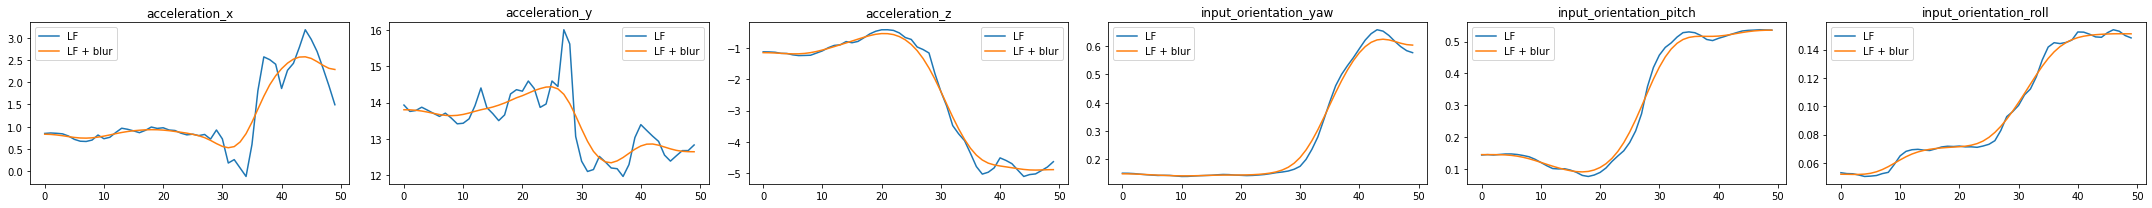

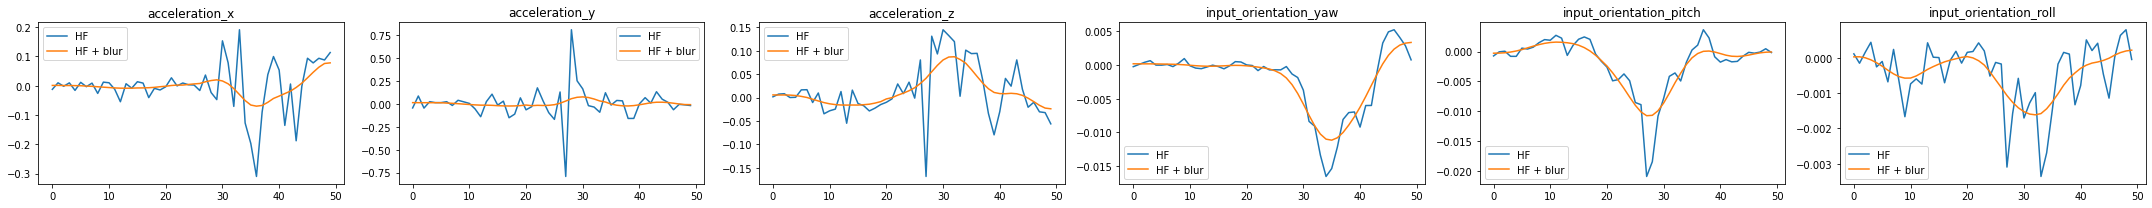

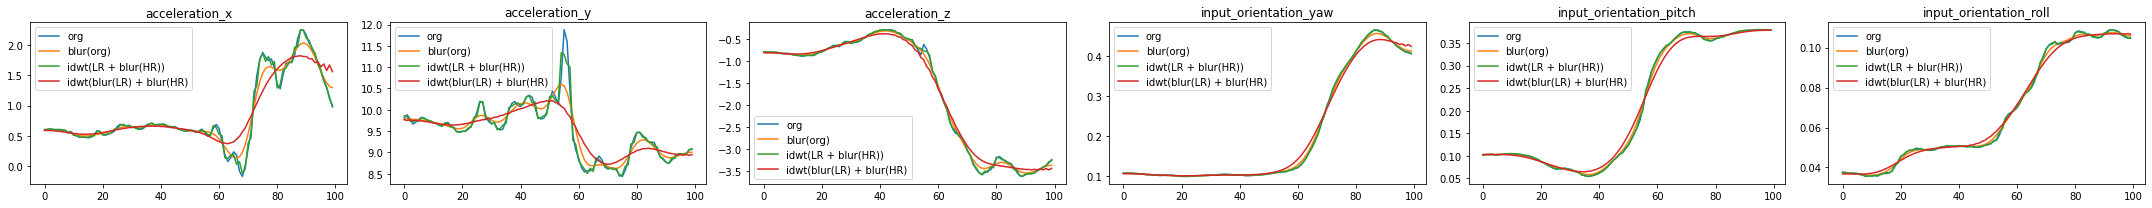



data/interpolation/interpolation_01.csv


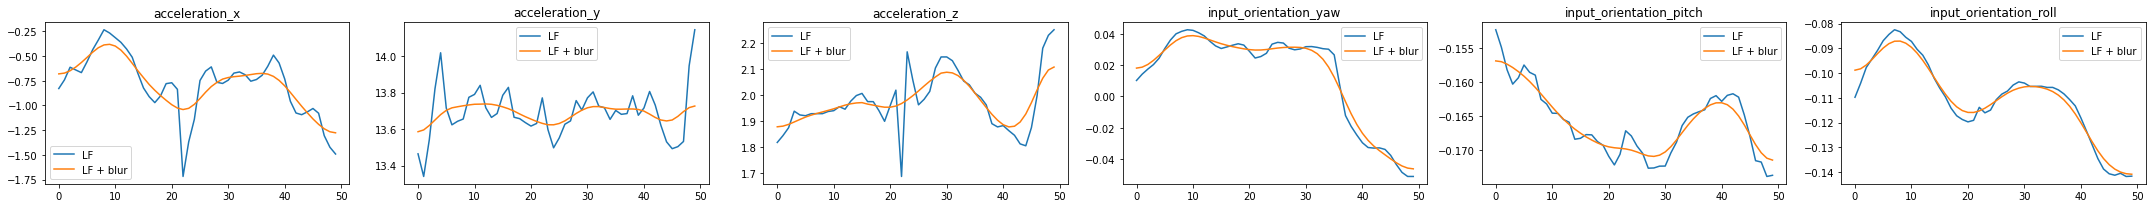

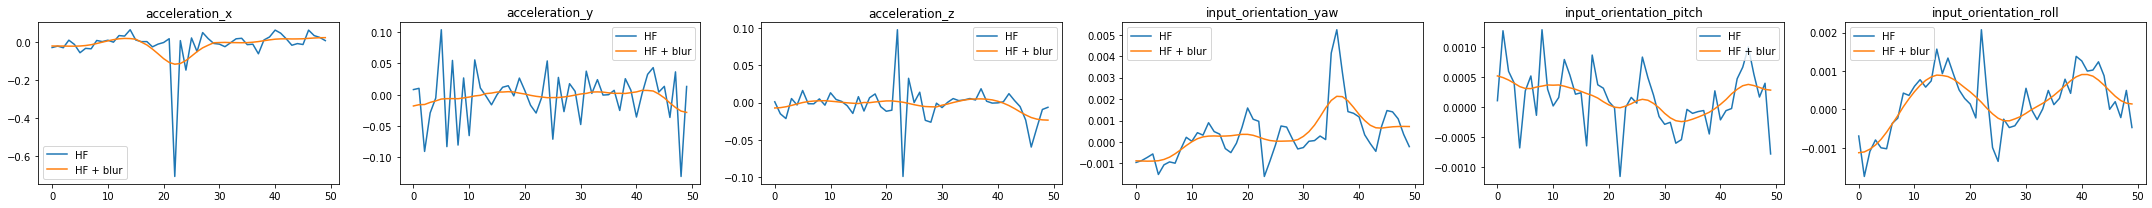

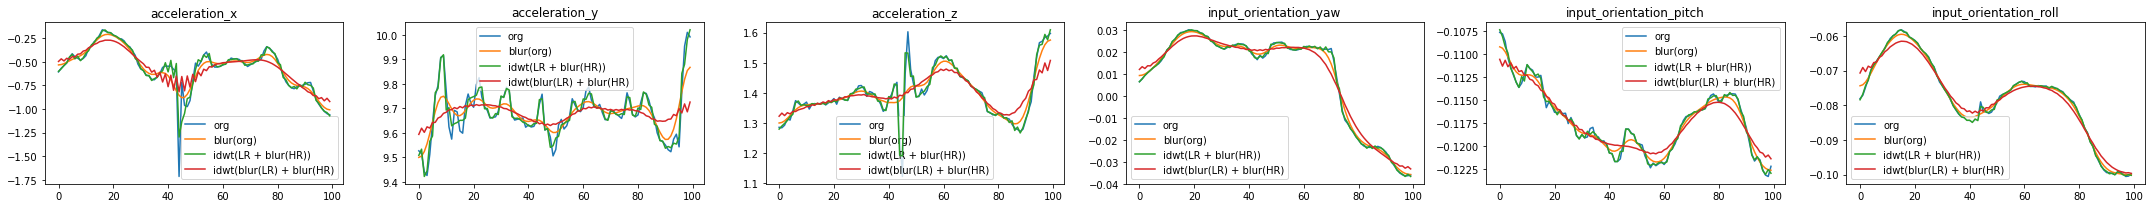



data/interpolation/interpolation_02.csv


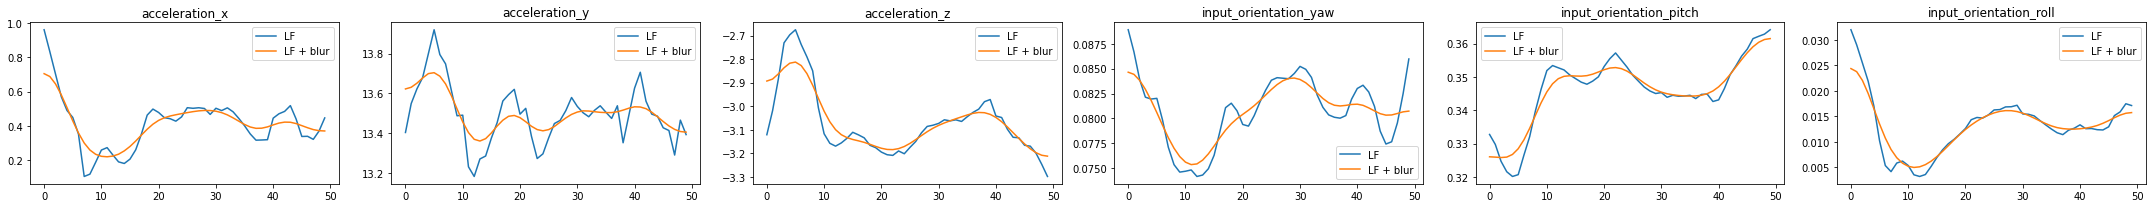

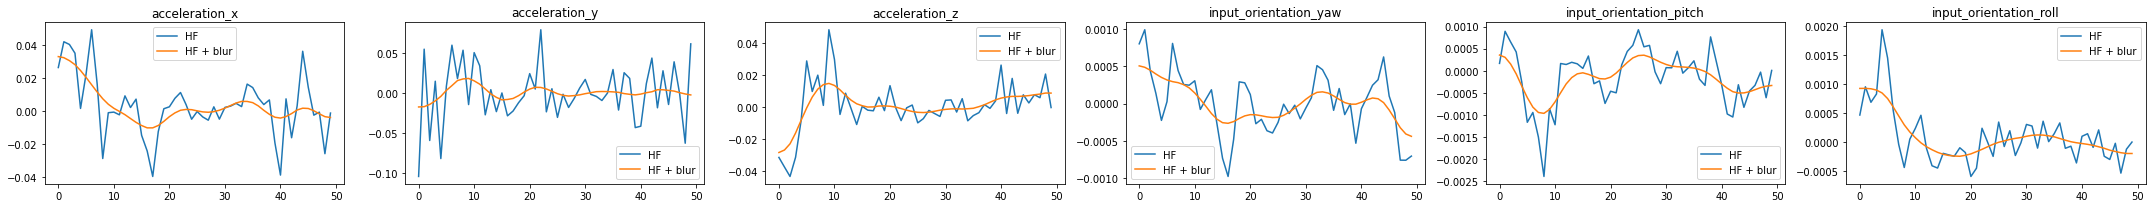

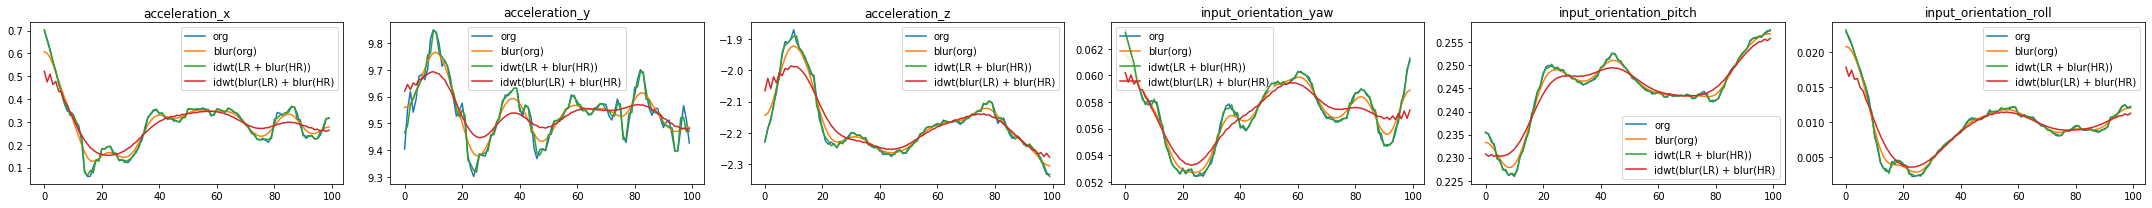



data/interpolation/interpolation_03.csv


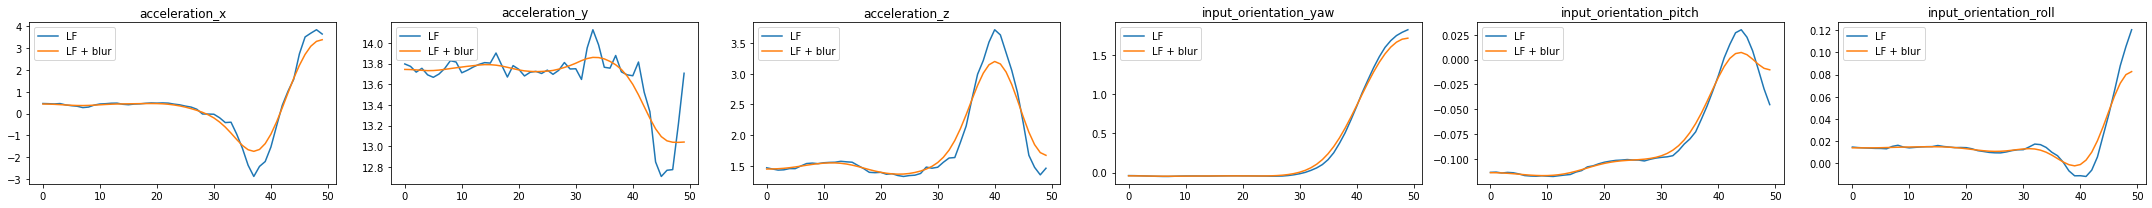

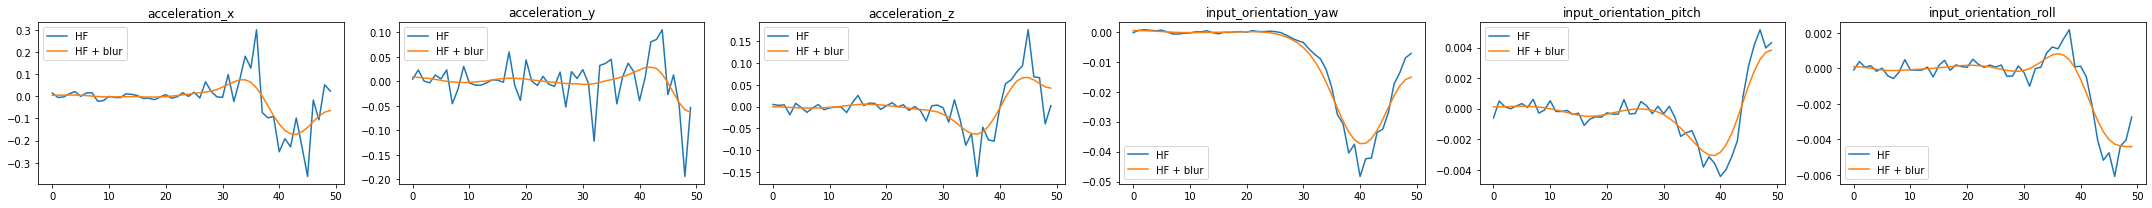

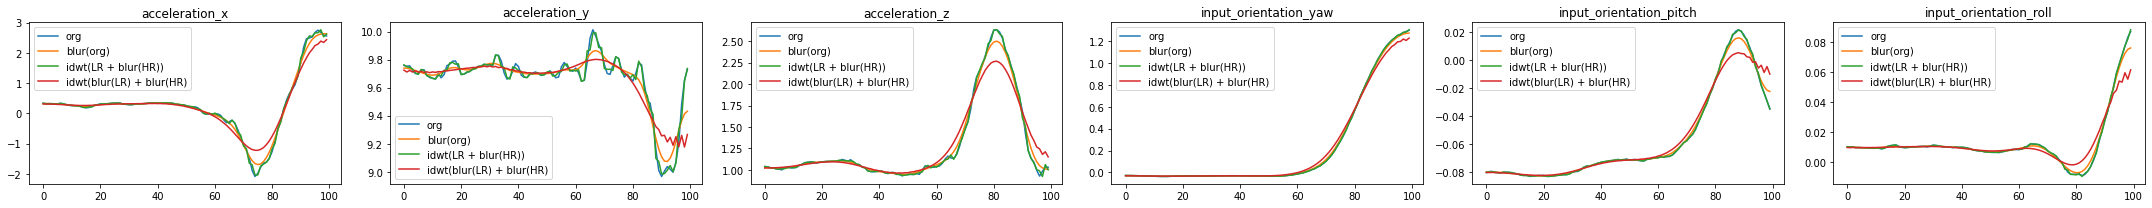



data/interpolation/interpolation_04.csv


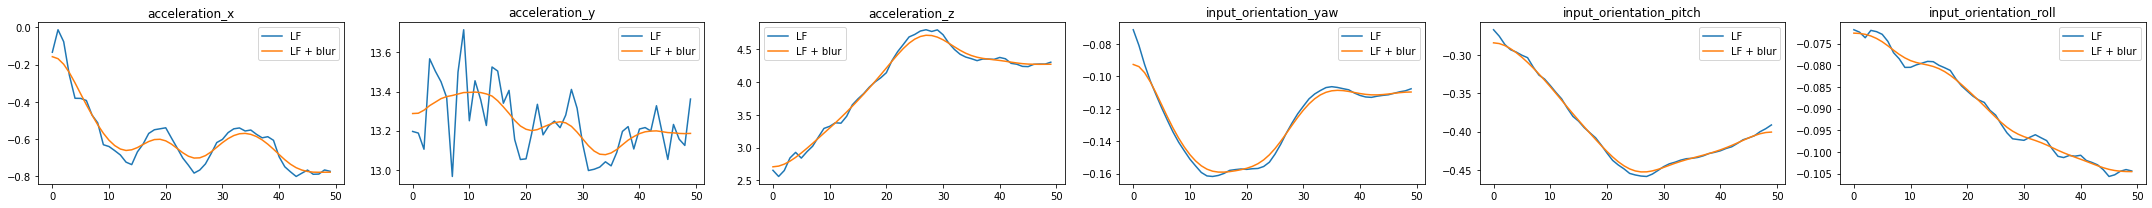

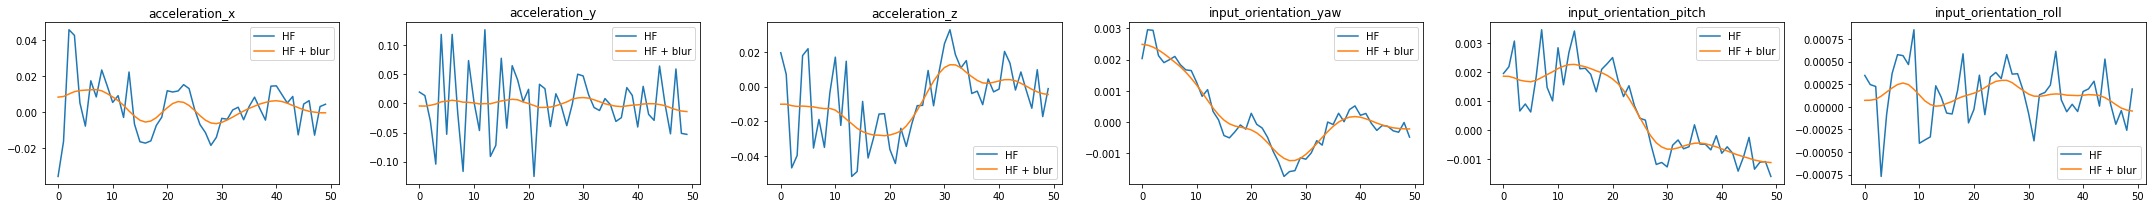

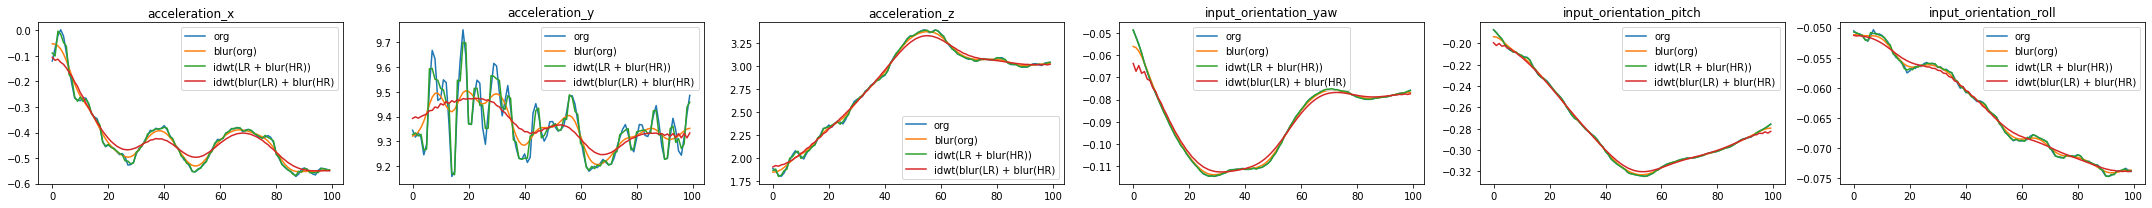



data/interpolation/interpolation_05.csv


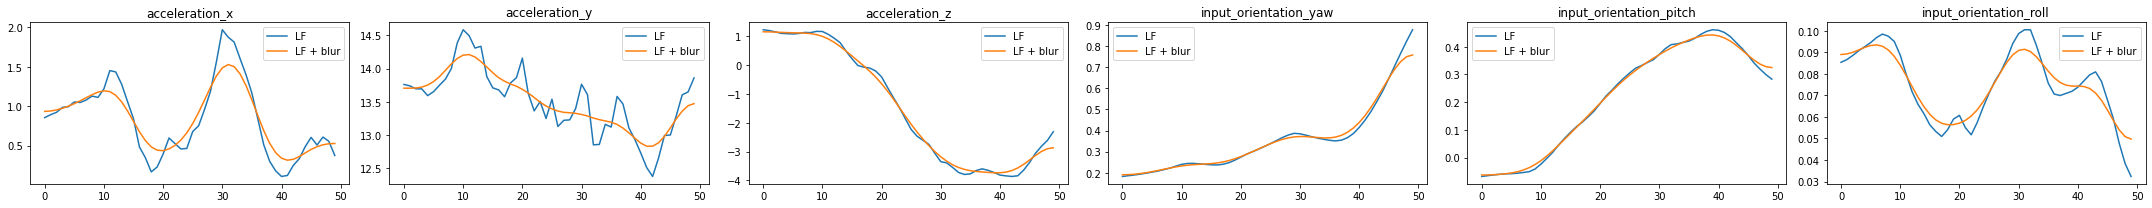

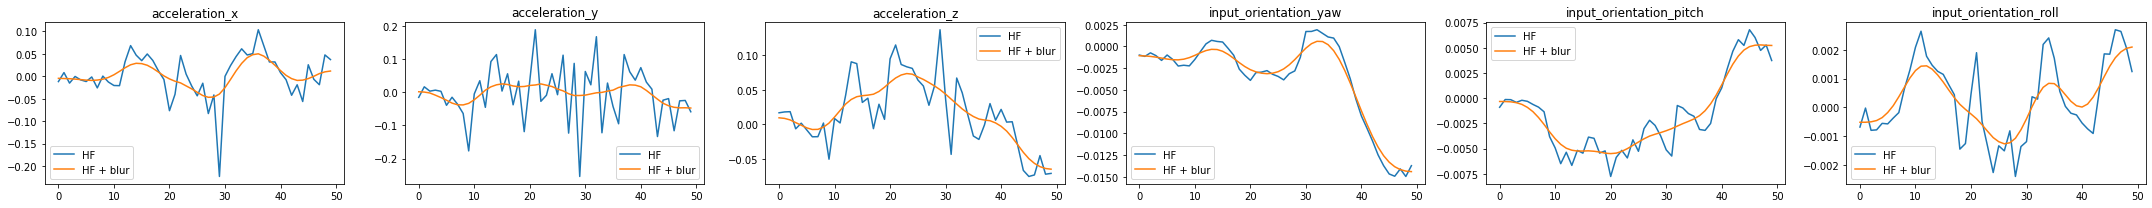

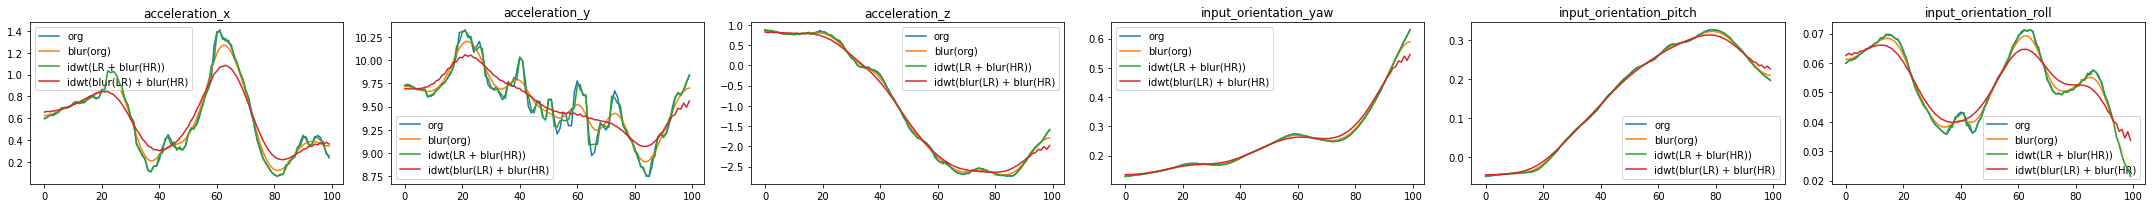



data/interpolation/interpolation_06.csv


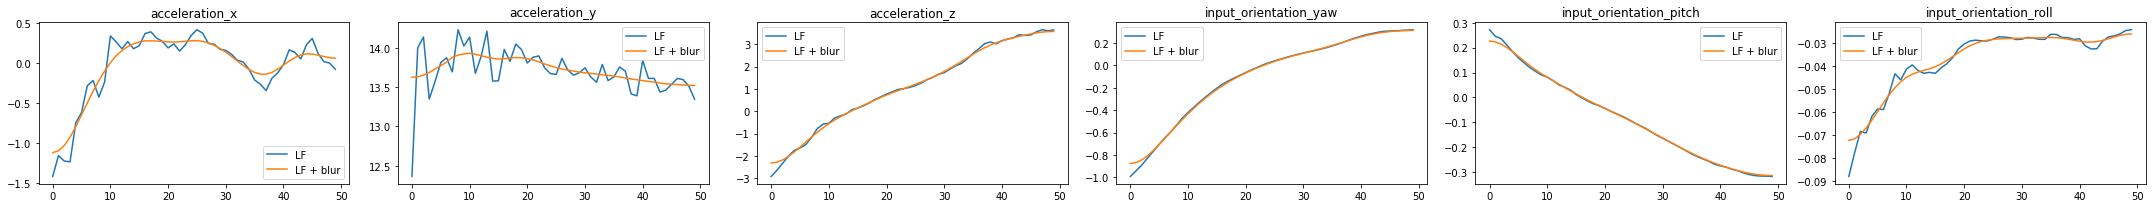

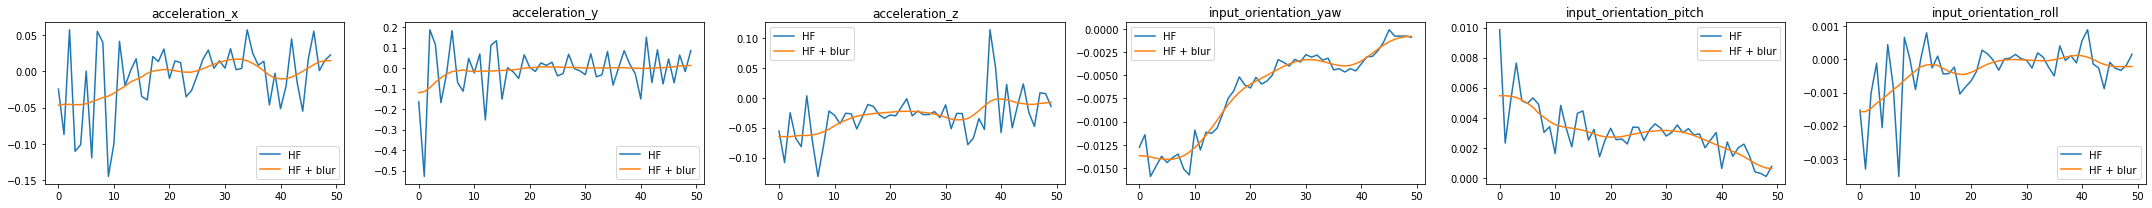

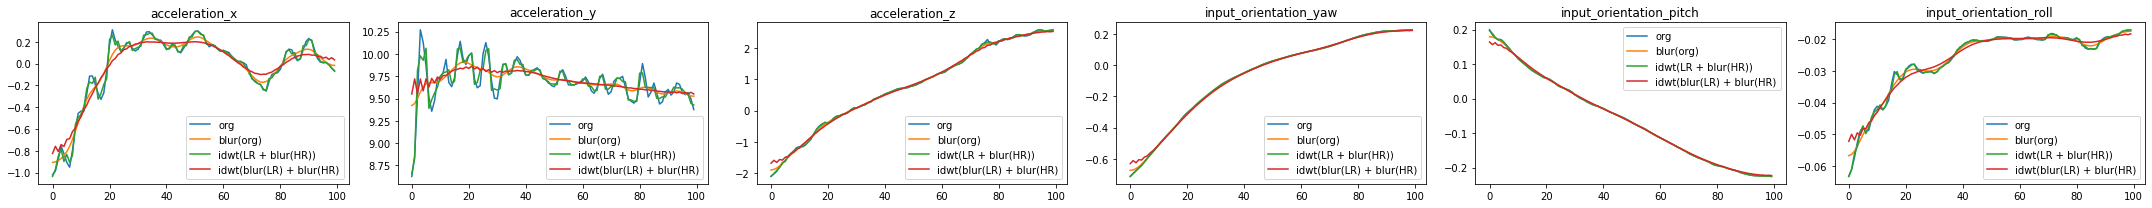



data/interpolation/interpolation_07.csv


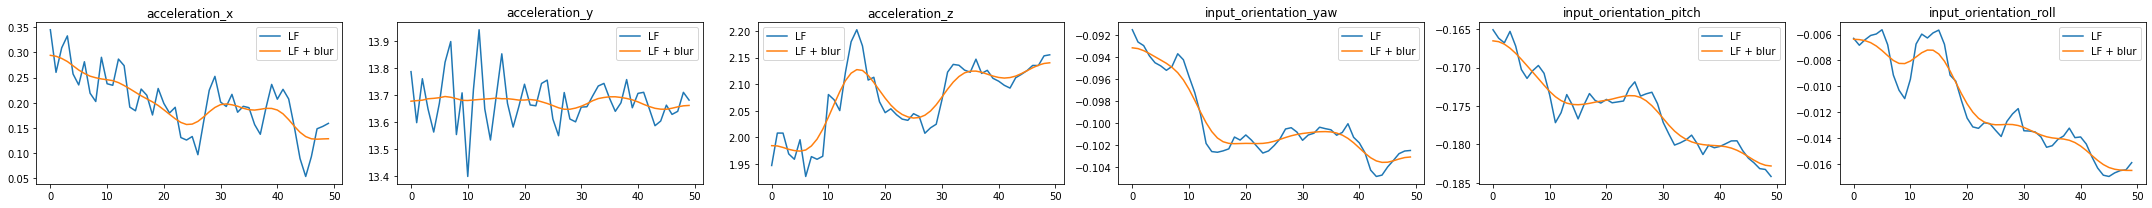

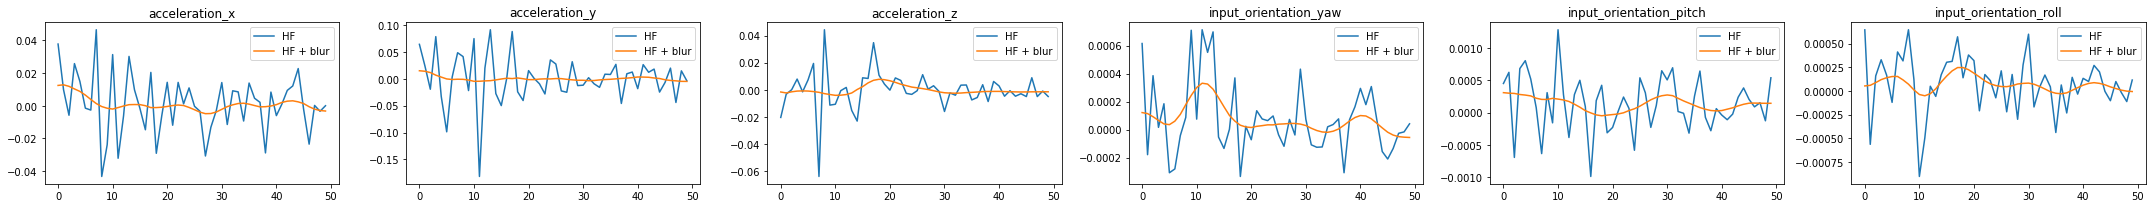

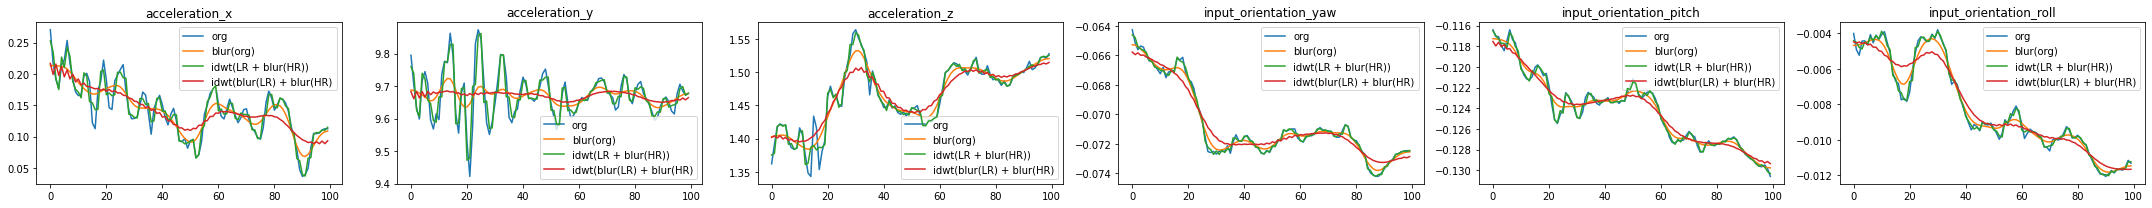



data/interpolation/interpolation_08.csv


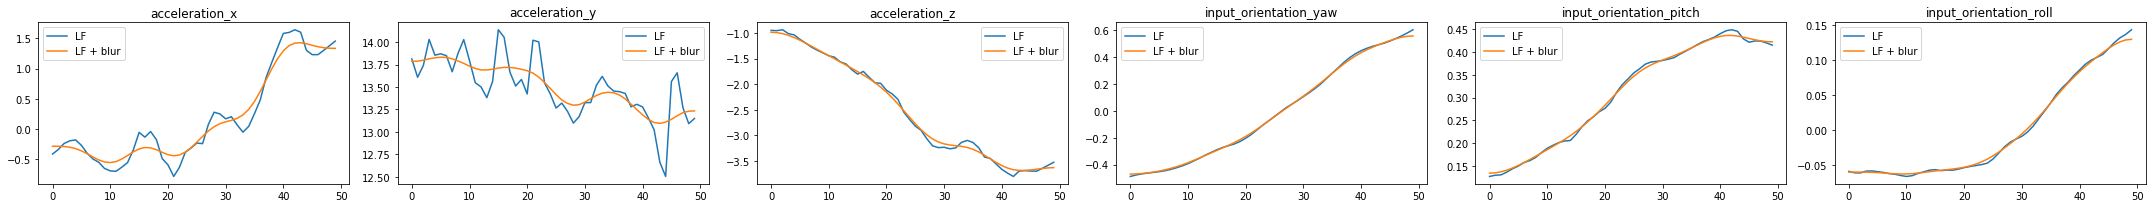

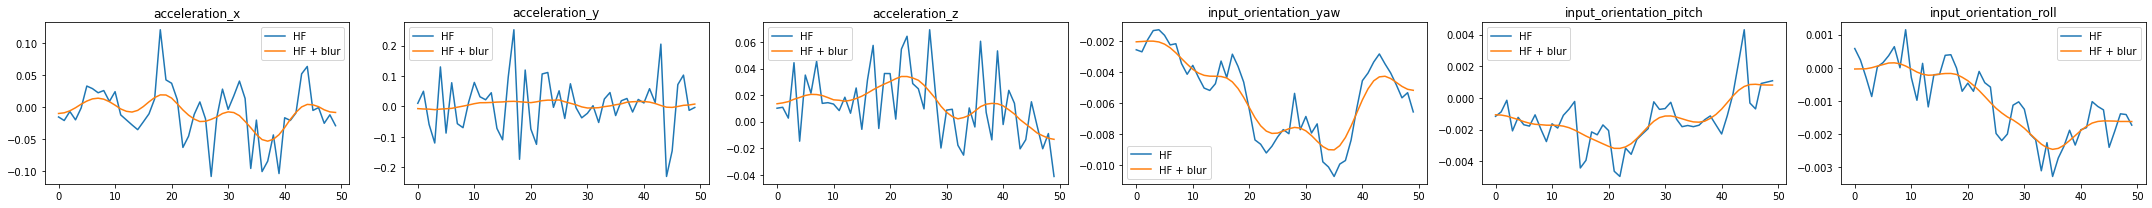

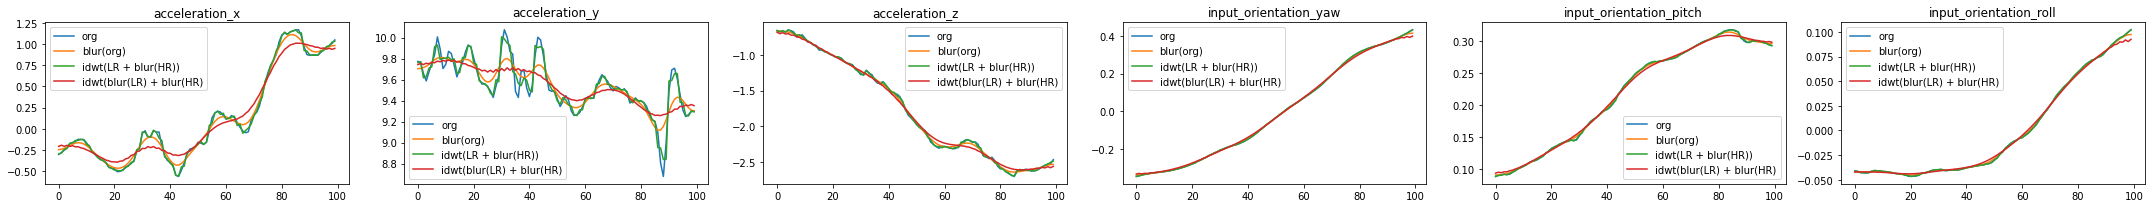



data/interpolation/interpolation_09.csv


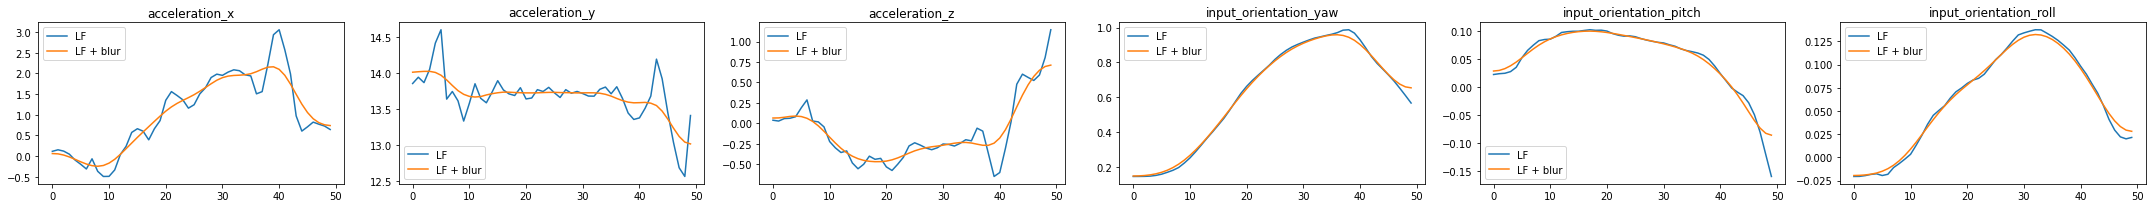

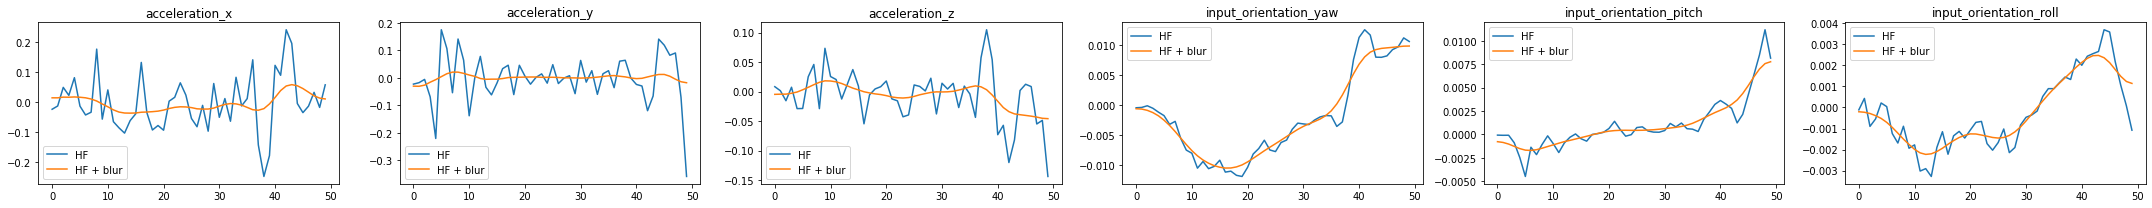

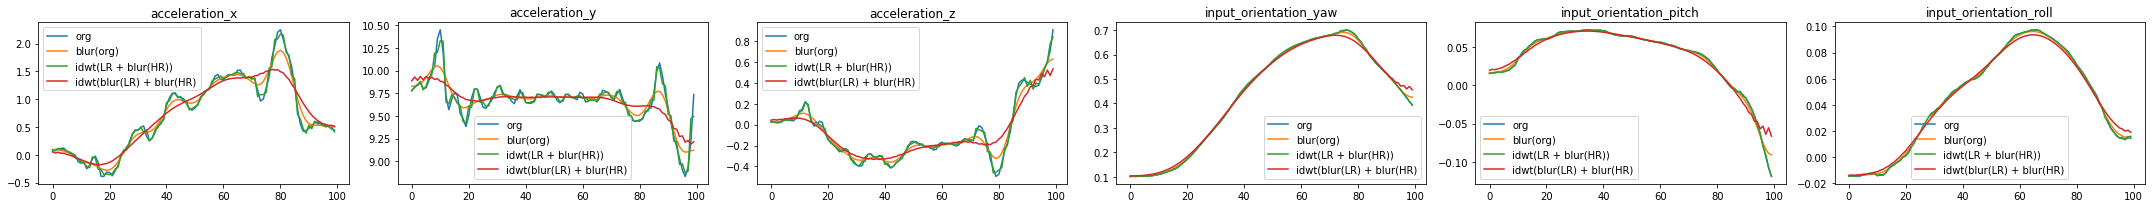



data/interpolation/interpolation_10.csv


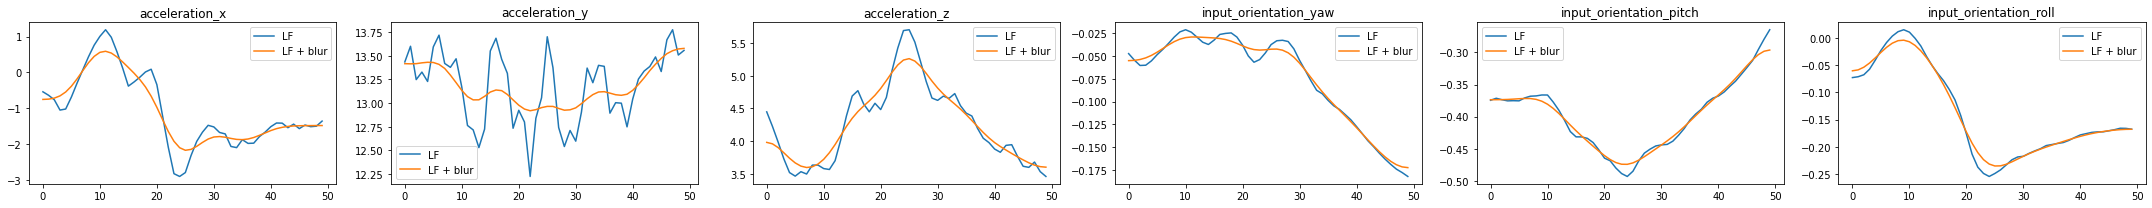

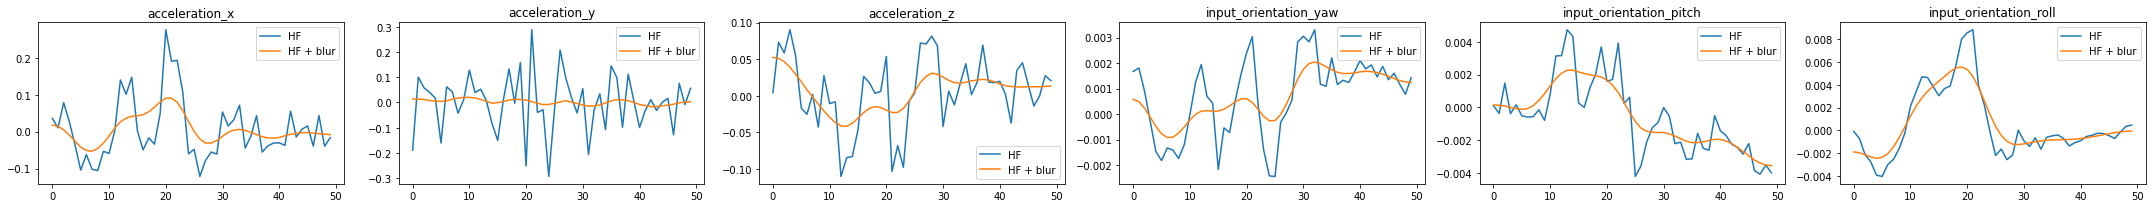

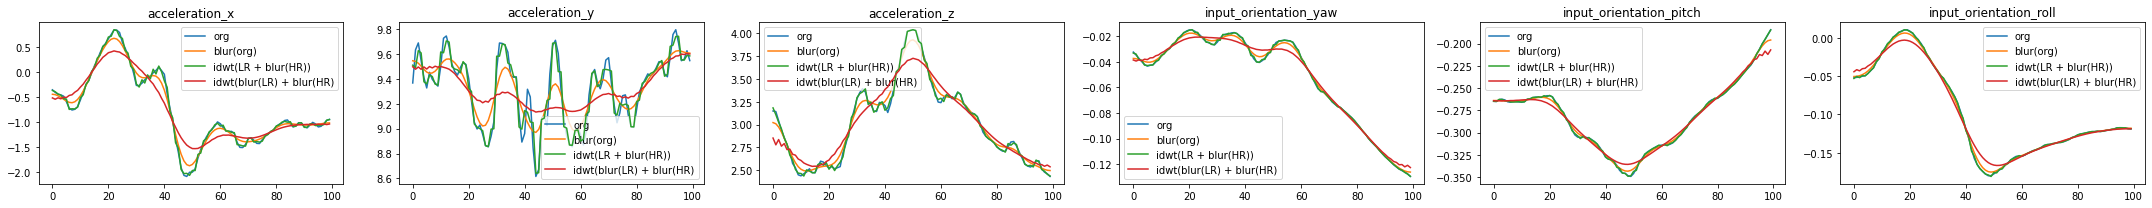



data/interpolation/interpolation_11.csv


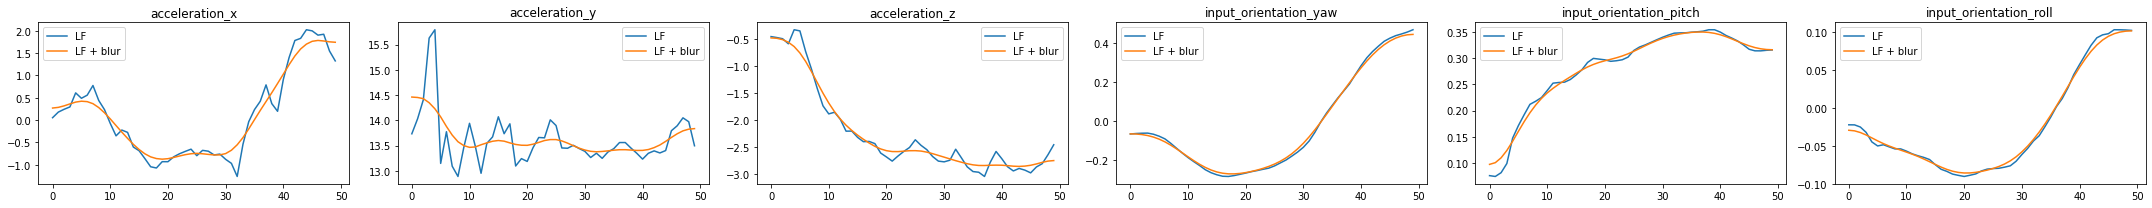

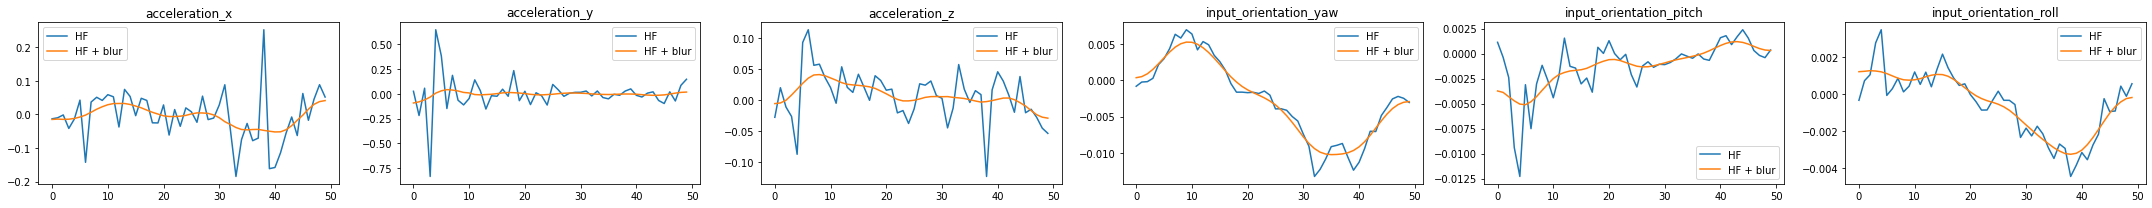

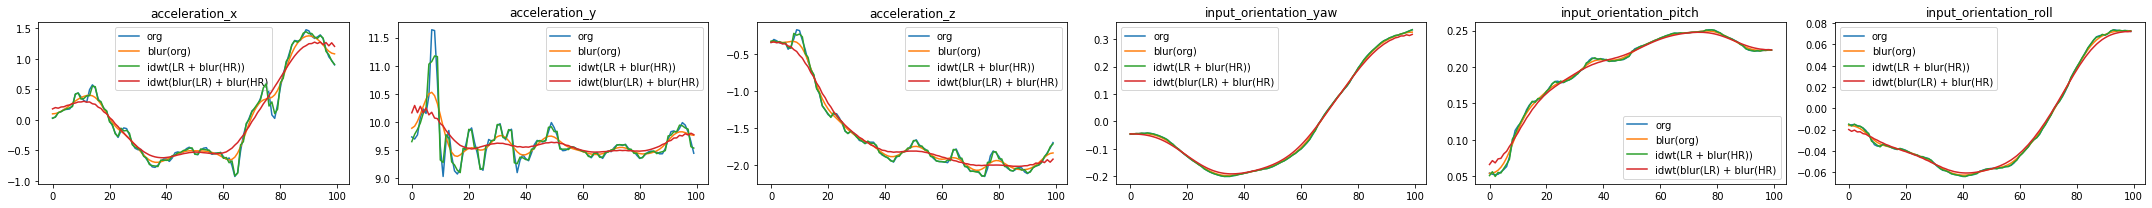



data/interpolation/interpolation_12.csv


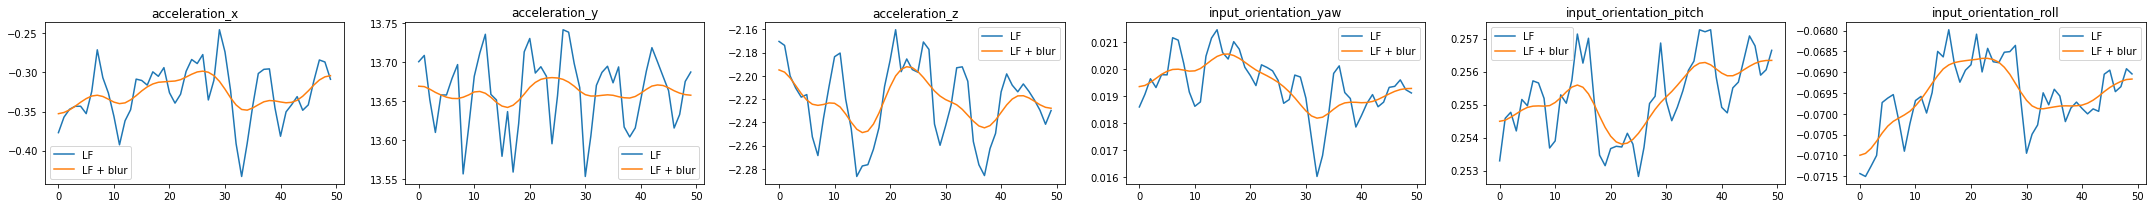

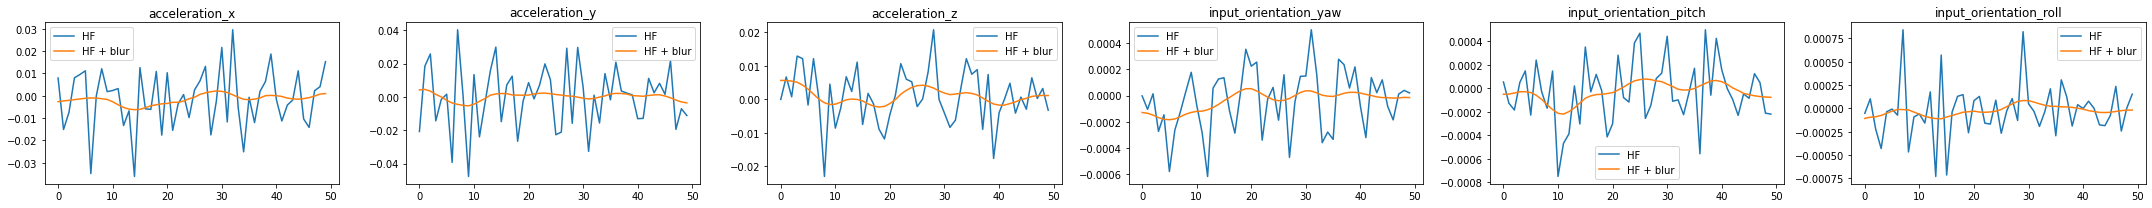

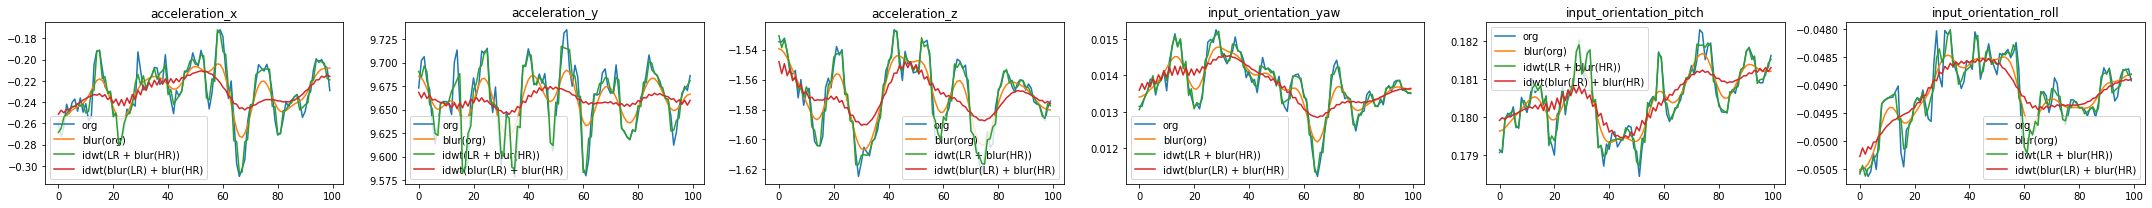



data/interpolation/interpolation_13.csv


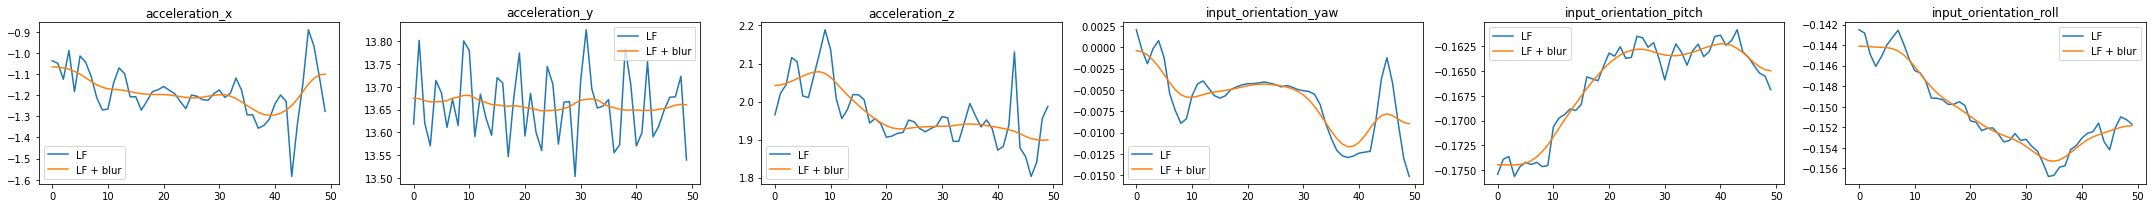

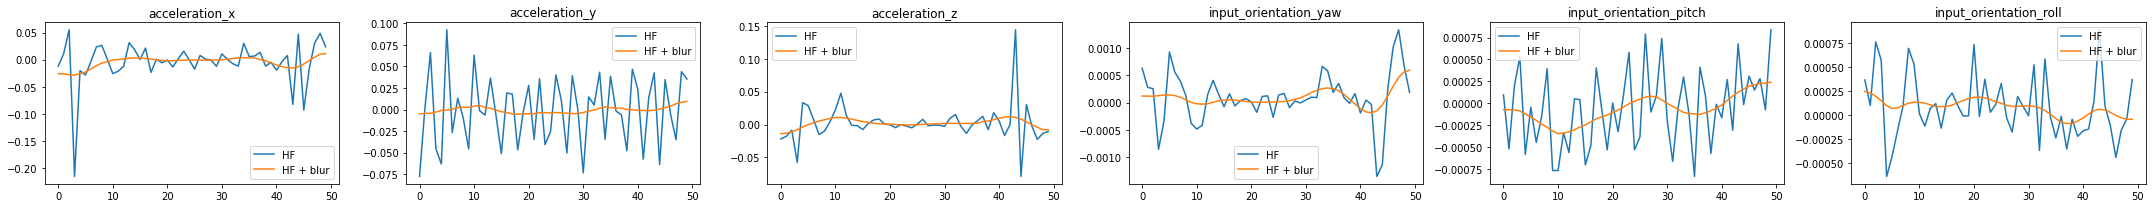

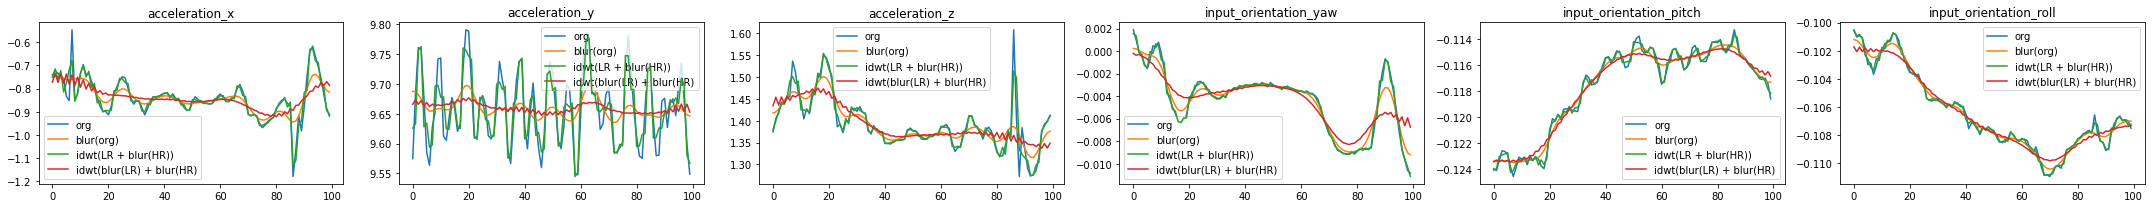



data/interpolation/interpolation_14.csv


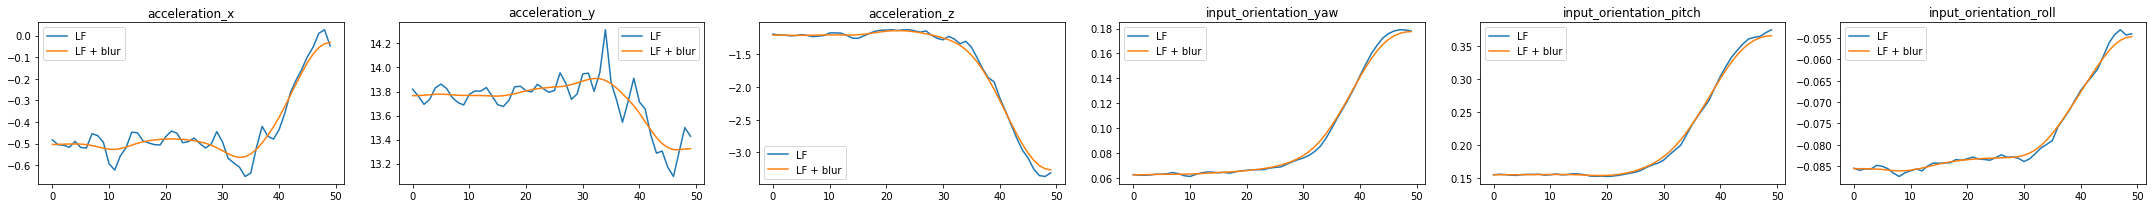

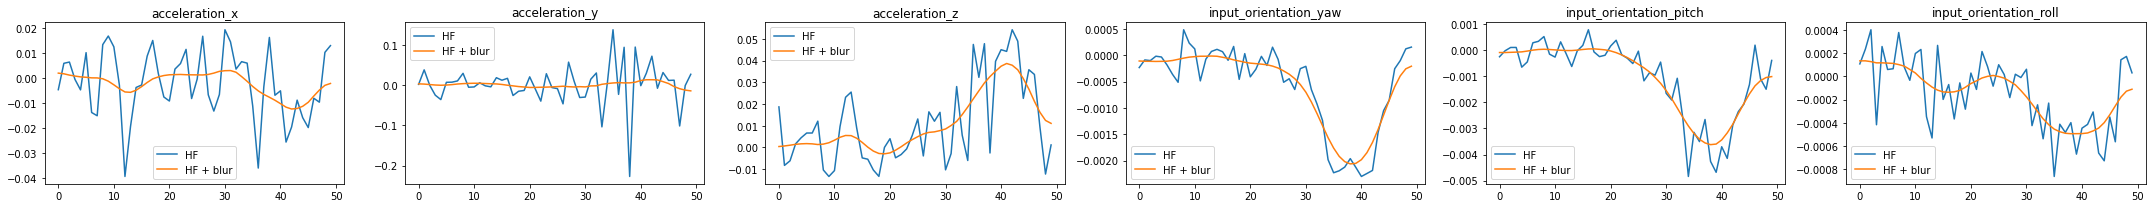

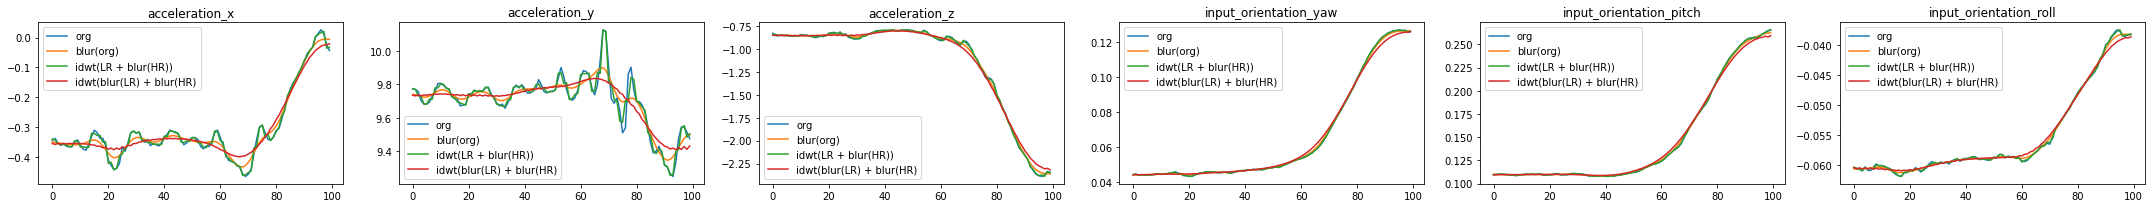



data/interpolation/interpolation_15.csv


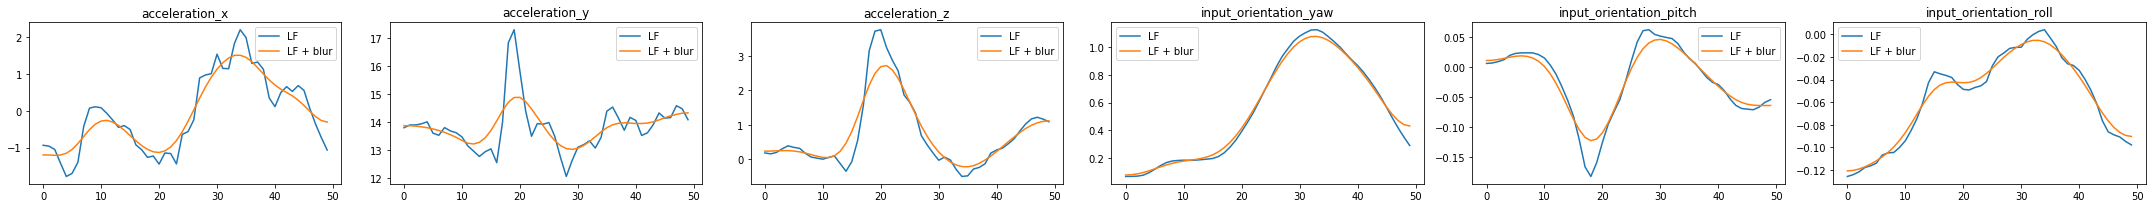

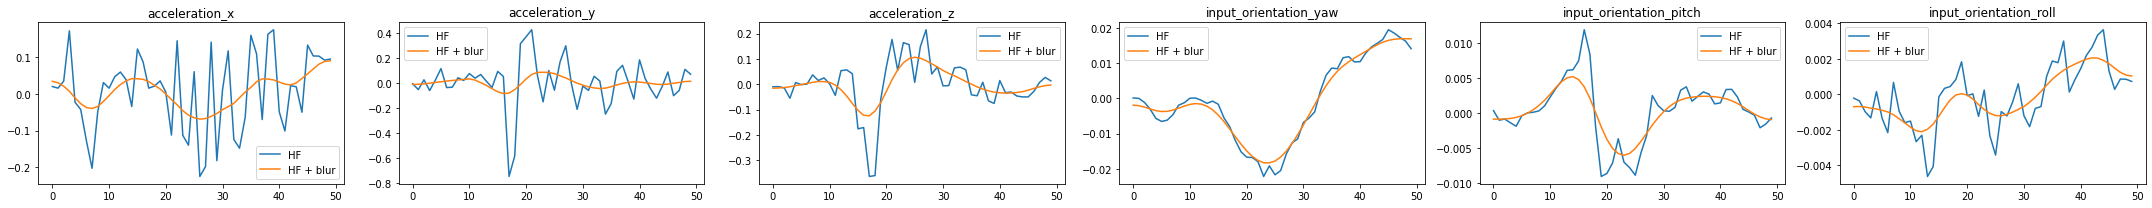

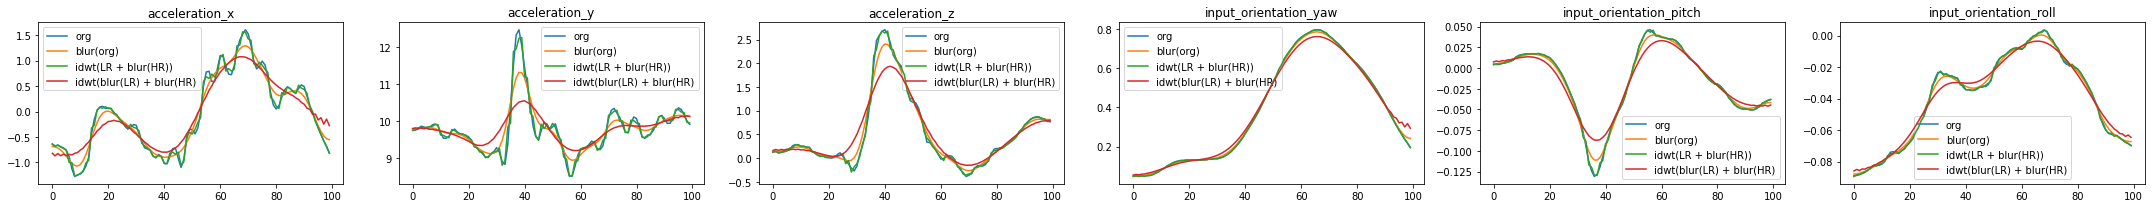



data/interpolation/interpolation_16.csv


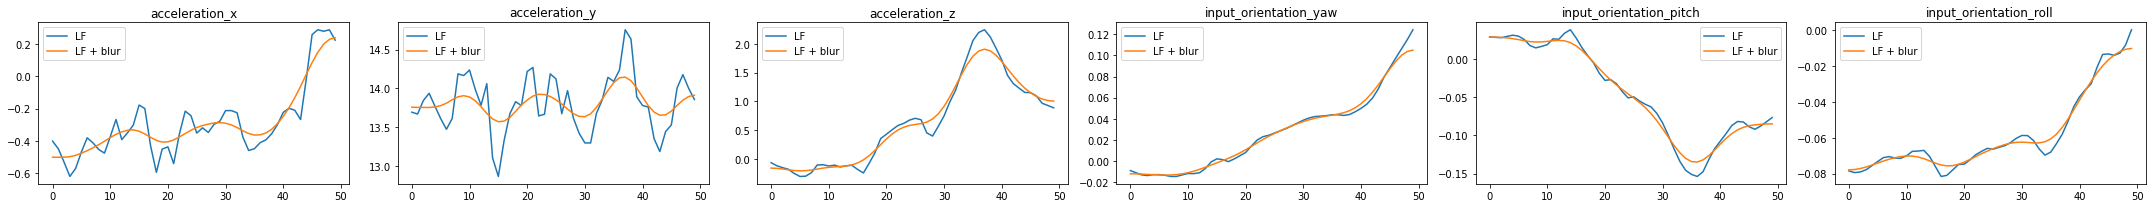

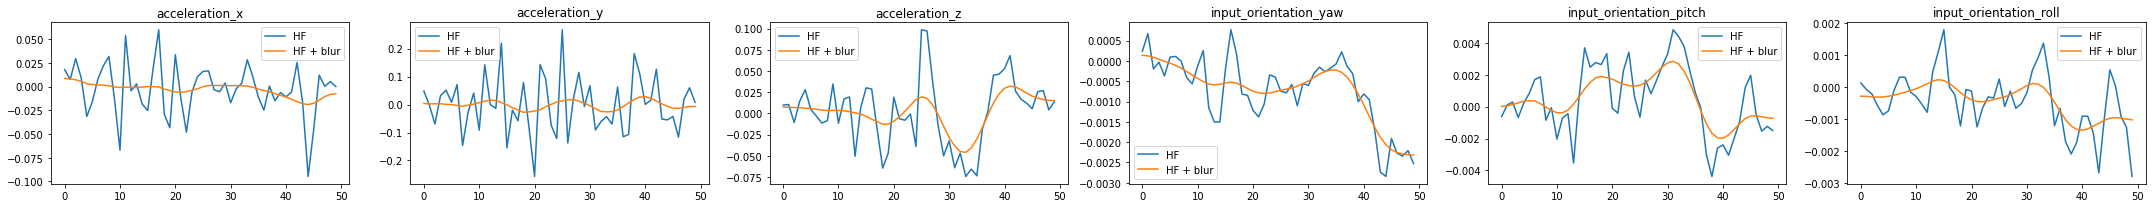

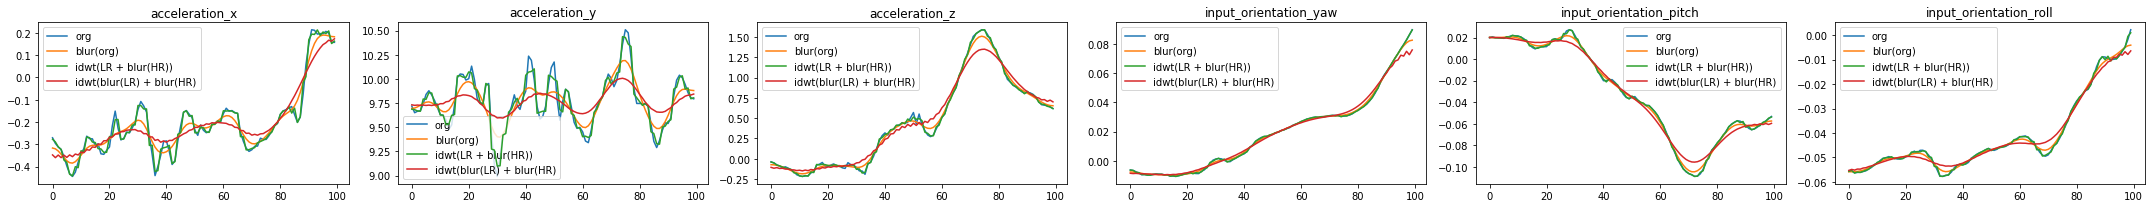



data/interpolation/interpolation_17.csv


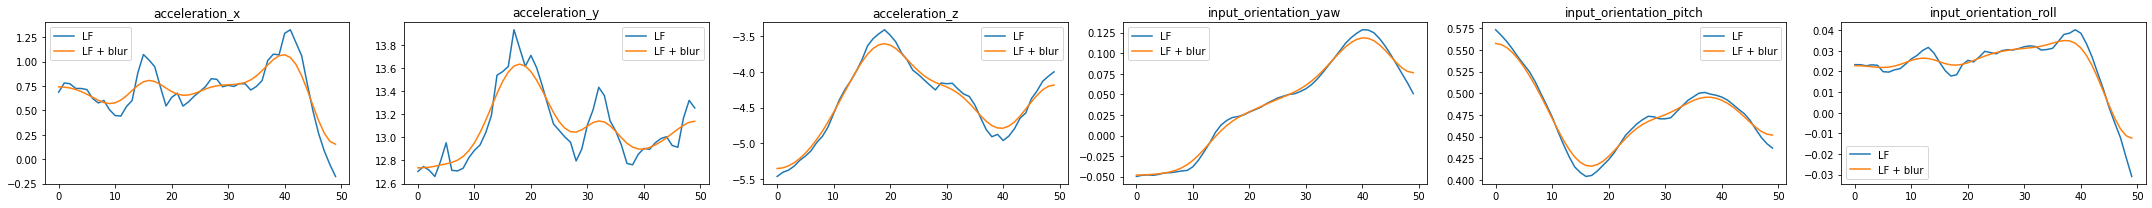

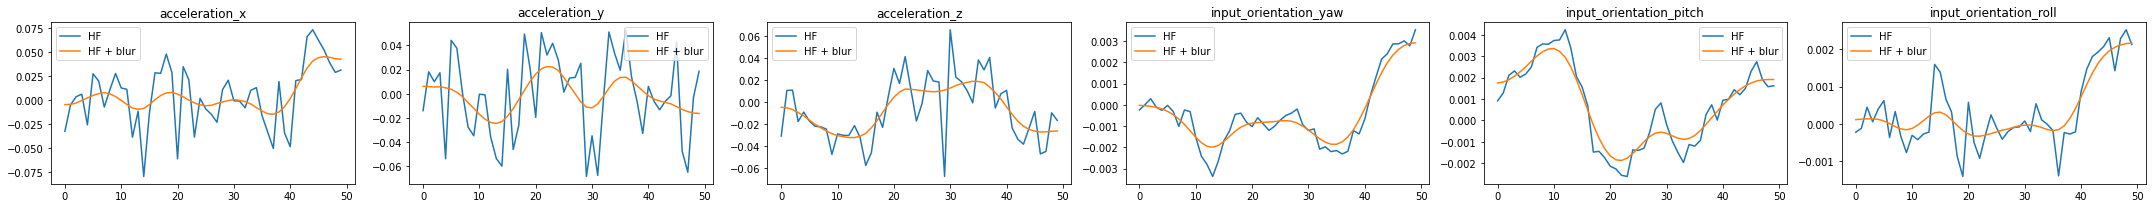

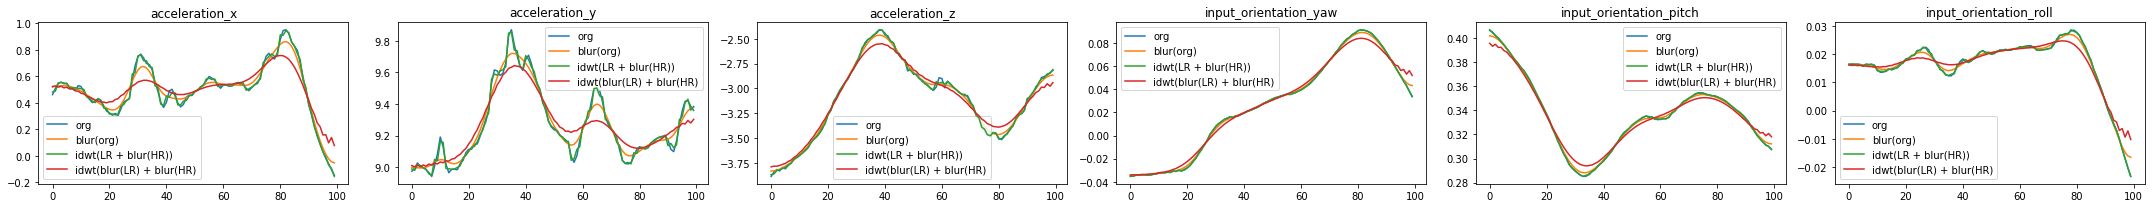



data/interpolation/interpolation_18.csv


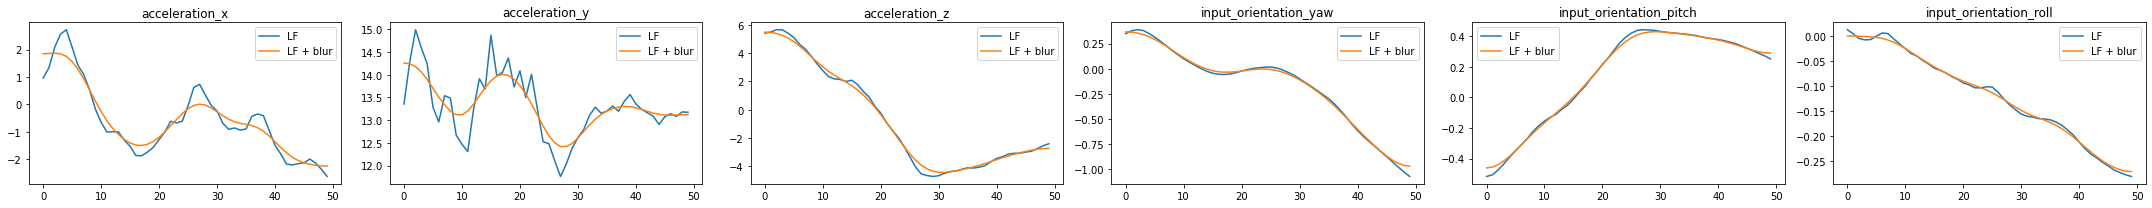

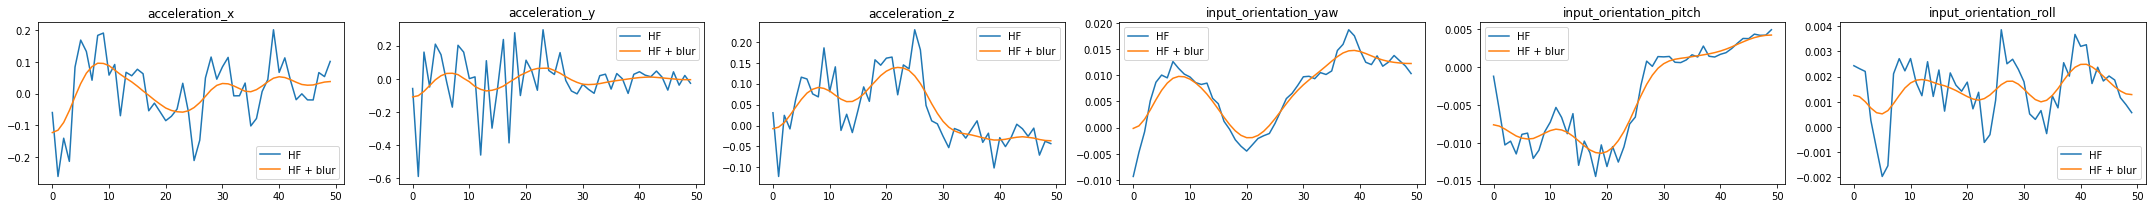

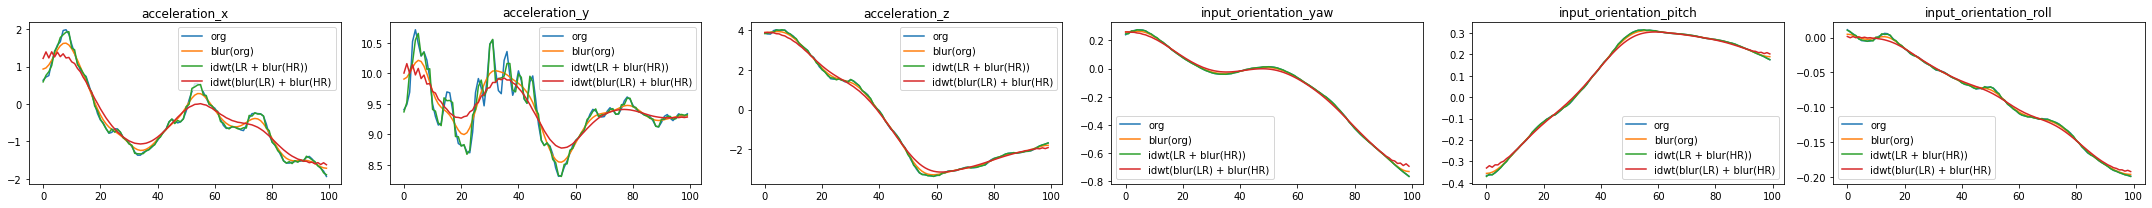



data/interpolation/interpolation_19.csv


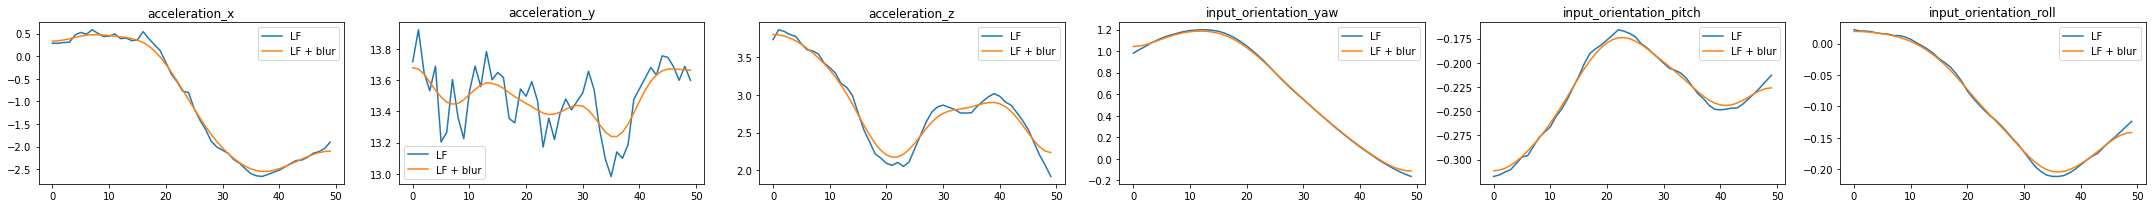

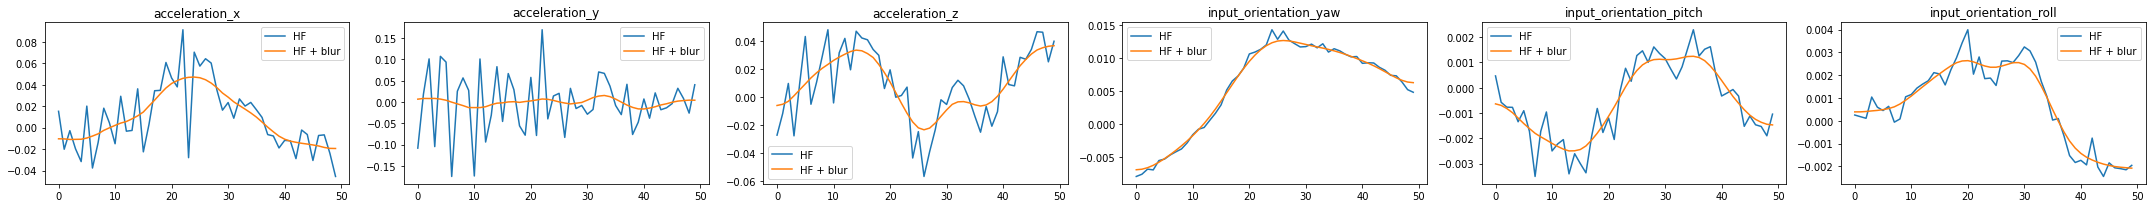

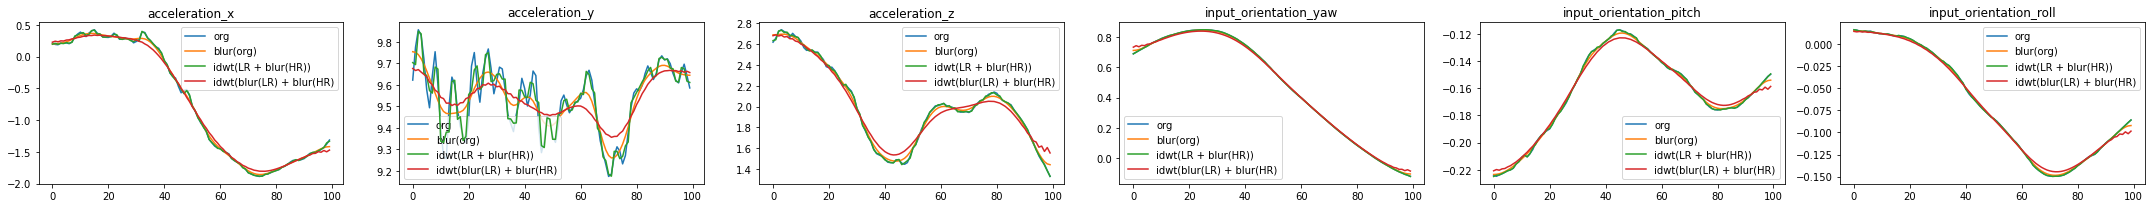



data/interpolation/interpolation_20.csv


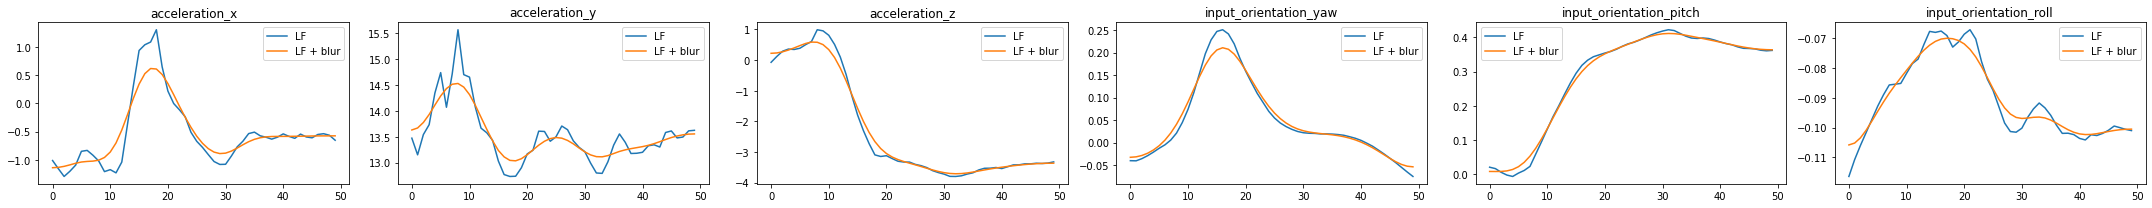

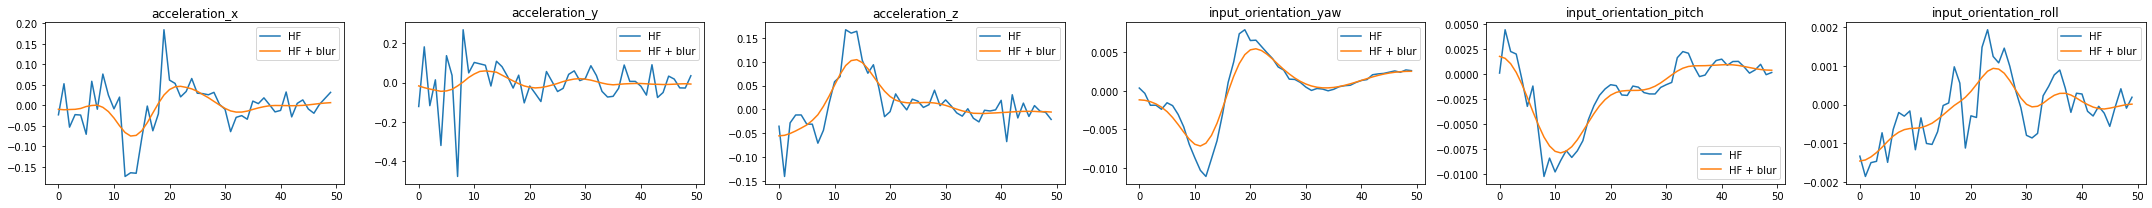

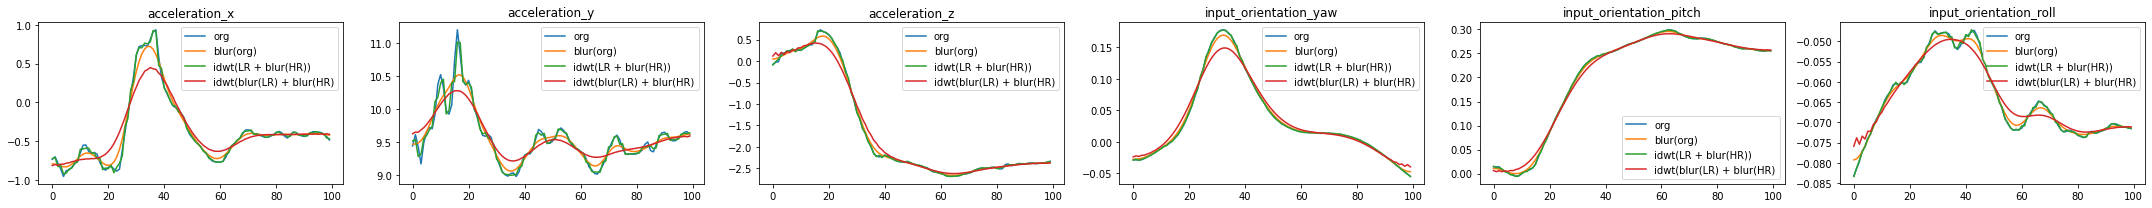



data/interpolation/interpolation_21.csv


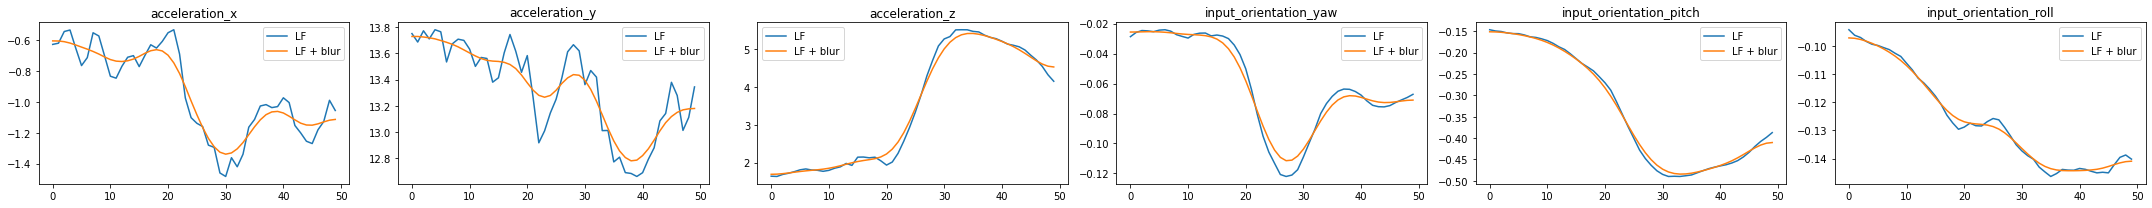

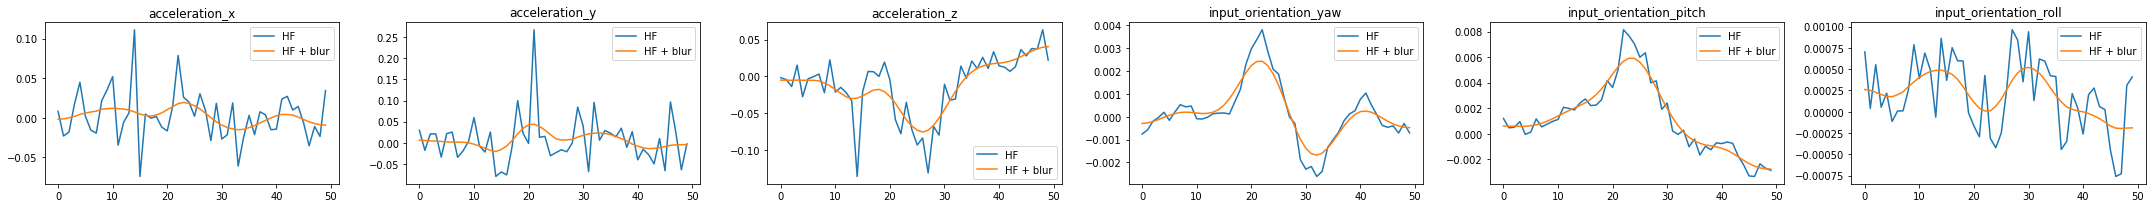

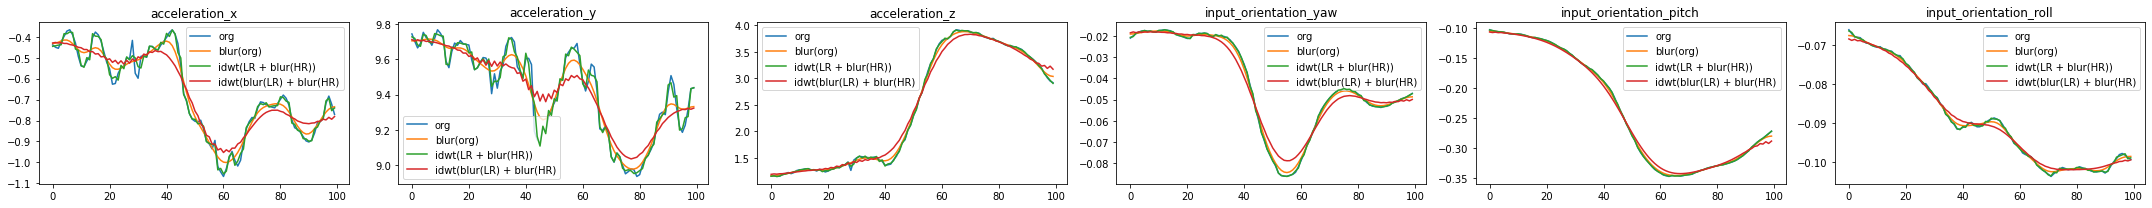

In [156]:
s = 100

for j in range(22):
    f = f'data/interpolation/interpolation_{j:02d}.csv'
    print(f)
    data = pd.read_csv(f)
    
    # LF + org
    plt.figure(figsize=(30, 3))
    for i, col in enumerate(cols, 1):
        d = data[col].to_numpy()[:s]
        l, h = pywt.dwt(d, wavelet)
        plt.subplot(1, len(cols), i)
        plt.plot(l)
        l = torch.tensor(l, dtype=torch.float32).view(1, 1, -1)
        l = g(l)
        l = l.squeeze().numpy()
        plt.plot(l)
        plt.title(col)
        plt.legend(['LF', 'LF + blur'])
    plt.tight_layout()
    plt.show()

    # HF
    plt.figure(figsize=(30, 3))
    for i, col in enumerate(cols, 1):
        d = data[col].to_numpy()[:s]
        l, h = pywt.dwt(d, wavelet)
        plt.subplot(1, len(cols), i)
        plt.plot(h)

        h = torch.tensor(h, dtype=torch.float32).view(1, 1, -1)
        h = g(h)
        h = h.squeeze().numpy()
        plt.plot(h)

        #plt.ylim(-1, 1)
        plt.title(col)
        plt.legend(['HF', 'HF + blur'])
    plt.tight_layout()
    plt.show()

    # org : idwt
    plt.figure(figsize=(30, 3))
    for i, col in enumerate(cols, 1):
        d = data[col].to_numpy()[:s]
        l, h = pywt.dwt(d, wavelet)
        
        plt.subplot(1, len(cols), i)
        plt.plot(d, zorder=0)
        
        d = torch.tensor(d, dtype=torch.float32).view(1, 1, -1)
        d = g(d)
        d = d.squeeze().numpy()

        h = torch.tensor(h, dtype=torch.float32).view(1, 1, -1)
        h = g(h)
        h = h.squeeze().numpy()
        
        bl = torch.tensor(l, dtype=torch.float32).view(1, 1, -1)
        bl = g(bl)
        bl = bl.squeeze().numpy()

        idwt = pywt.idwt(l, h, wavelet)
        idwt2 = pywt.idwt(bl, h, wavelet)

        plt.plot(d, zorder=5)
        plt.plot(idwt, zorder=10)
        plt.plot(idwt2, zorder=15)

        #plt.ylim(-1, 1)
        plt.title(col)
        plt.legend(['org', 'blur(org)', 'idwt(LR + blur(HR))', 'idwt(blur(LR) + blur(HR)'])
    plt.tight_layout()
    plt.show()
    print('\n')